# Audio Analysis with torchaudio

This notebook applies exploratory workflow. We will:
1. Collect all `.m4a` files from two folders (males, females).
2. Use **torchaudio** to load each file and extract basic info (duration, sample rate, etc.).
3. Store the data in a **pandas DataFrame**.
4. Display summary statistics and histograms of durations.
5. Show a few random audio samples.

In [1]:
import os
import pandas as pd
import torchaudio
import matplotlib.pyplot as plt
from IPython.display import Audio, display

# Folders with .m4a audio files
MALE_FOLDER = "/home/noor-alaa/Documents/Cyshield/data/VoxCeleb_gender/males"
FEMALE_FOLDER = "/home/noor-alaa/Documents/Cyshield/data/VoxCeleb_gender/females"

## 1. Collect all `.m4a` files from each folder

In [2]:
def list_m4a_files(folder_path, label):
    """
    Finds all .m4a files in `folder_path` (not recursive by default).
    Returns a list of tuples (full_path, label).
    """
    results = []
    for fname in os.listdir(folder_path):
        if fname.lower().endswith(".m4a"):
            full_path = os.path.join(folder_path, fname)
            results.append((full_path, label))
    return results

male_files = list_m4a_files(MALE_FOLDER, "M")
female_files = list_m4a_files(FEMALE_FOLDER, "F")

all_files = male_files + female_files
print(f"Found {len(male_files)} male files.")
print(f"Found {len(female_files)} female files.")
print(f"Total audio files: {len(all_files)}")

Found 3682 male files.
Found 2311 female files.
Total audio files: 5993


## 2. Define a function to load each file and gather stats
We'll extract duration (in seconds), sample rate, and number of channels (like in the script).

In [3]:
def analyze_audio_file(file_path):
    """
    Loads an audio file with torchaudio, returning a dict with:
      - duration (float, in seconds)
      - sample_rate (int)
      - channels (int)
    """
    try:
        waveform, sr = torchaudio.load(file_path)
        # waveform shape: (channels, time)
        num_channels = waveform.shape[0]
        duration_sec = waveform.shape[1] / sr
        return {
            "sample_rate": sr,
            "channels": num_channels,
            "duration_sec": duration_sec
        }
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

## 3. Loop over all files, build a DataFrame
We'll store `filepath`, `label`, `duration_sec`, `sample_rate`, `channels`. Then we'll do some analysis.

In [4]:
records = []

for path, label in all_files:
    info = analyze_audio_file(path)
    if info is not None:
        # append a record with all info
        records.append({
            "filepath": path,
            "label": label,
            **info  # merges dictionary keys from info
        })

df = pd.DataFrame(records)
print(f"Successfully loaded {len(df)} audio files.")
df.head()

Successfully loaded 5993 audio files.


,filepath,label,sample_rate,channels,duration_sec
0,/home/noor-alaa/Documents/Cyshield/data/VoxCel...,M,16000,1,15.232
1,/home/noor-alaa/Documents/Cyshield/data/VoxCel...,M,16000,1,7.040
2,/home/noor-alaa/Documents/Cyshield/data/VoxCel...,M,16000,1,7.296
3,/home/noor-alaa/Documents/Cyshield/data/VoxCel...,M,16000,1,4.416
4,/home/noor-alaa/Documents/Cyshield/data/VoxCel...,M,16000,1,4.032


## 4. Basic info about the DataFrame

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5993 entries, 0 to 5992
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   filepath      5993 non-null   object 
 1   label         5993 non-null   object 
 2   sample_rate   5993 non-null   int64  
 3   channels      5993 non-null   int64  
 4   duration_sec  5993 non-null   float64
dtypes: float64(1), int64(2), object(2)
memory usage: 234.2+ KB


In [6]:
df.describe()

,sample_rate,channels,duration_sec
count,5993.0,5993.0,5993.000000
mean,16000.0,1.0,6.995543
std,0.0,0.0,4.722393
min,16000.0,1.0,3.968000
25%,16000.0,1.0,4.544000
50%,16000.0,1.0,5.504000
75%,16000.0,1.0,7.616000
max,16000.0,1.0,91.008000


### Grouped statistics by `label` (M/F)

In [7]:
df.groupby("label").agg({
    "duration_sec": ["count", "mean", "std", "min", "max"],
    "sample_rate": ["nunique"]
})

duration_sec                                    sample_rate
             count      mean       std    min     max     nunique
label                                                            
F             2311  7.157587  4.837045  3.968  67.712           1
M             3682  6.893836  4.646765  3.968  91.008           1

## 5. Visualize distribution of durations
We'll do two histograms: one for males, one for females, overlaid.

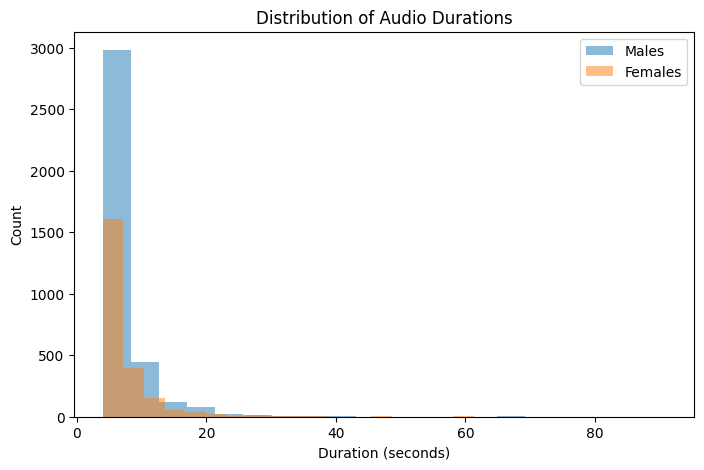

In [8]:
male_duration = df[df["label"] == "M"]["duration_sec"]
female_duration = df[df["label"] == "F"]["duration_sec"]

plt.figure(figsize=(8,5))
plt.hist(male_duration, alpha=0.5, bins=20, label="Males")
plt.hist(female_duration, alpha=0.5, bins=20, label="Females")
plt.title("Distribution of Audio Durations")
plt.xlabel("Duration (seconds)")
plt.ylabel("Count")
plt.legend()
plt.show()

## 6. Listen to a few random samples
We'll pick two random males and two random females and embed them in the notebook (assuming you have audio playback support).

In [9]:
def listen_to_random_samples(df, label, n=2):
    """
    Pick n random rows for the given label (M or F),
    display basic info, and embed an audio player.
    """
    subset = df[df["label"] == label]
    samples = subset.sample(n=min(n, len(subset)))
    for i, row in samples.iterrows():
        path = row["filepath"]
        duration = row["duration_sec"]
        sr = row["sample_rate"]
        print(f"Label: {label}, Duration: {duration:.2f}s, SR: {sr}")
        print(f"File: {path}\n")
        display(Audio(path, autoplay=False))
        print("-" * 80)

# Listen to random male and female samples
listen_to_random_samples(df, "M", n=2)
listen_to_random_samples(df, "F", n=2)

Label: M, Duration: 4.10s, SR: 16000
File: /home/noor-alaa/Documents/Cyshield/data/VoxCeleb_gender/males/884.m4a



--------------------------------------------------------------------------------
Label: M, Duration: 6.14s, SR: 16000
File: /home/noor-alaa/Documents/Cyshield/data/VoxCeleb_gender/males/2530.m4a



--------------------------------------------------------------------------------
Label: F, Duration: 10.37s, SR: 16000
File: /home/noor-alaa/Documents/Cyshield/data/VoxCeleb_gender/females/507.m4a



--------------------------------------------------------------------------------
Label: F, Duration: 5.12s, SR: 16000
File: /home/noor-alaa/Documents/Cyshield/data/VoxCeleb_gender/females/317.m4a



--------------------------------------------------------------------------------
